In [ ]:
#Install required mods - suppress outputs
!pip install contractions &> /dev/null
!pip install --upgrade gensim &> /dev/null
! pip install -U memory_profiler


  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp36-none-any.whl size=30181 sha256=d2842a37faacda7fa0bb0eb11ed89637e83cd5d918b1da34fbd4c1d6bec224f3
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


In [ ]:
try:
    import pandas as pd
    import numpy as np
    import sys, os
    import string
    import re, string, unicodedata
    import contractions
    import operator 
    import re
    import multiprocessing
    from absl import logging
    import uuid
    import matplotlib.pyplot as plt
    import seaborn as sns
    import time
    import resource 
    #sklearn
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity

    #spacy
    import spacy 

    #nltk
    import nltk

    #nltk downloads
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')
    
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize

    from nltk.tokenize import RegexpTokenizer
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer

    #stopwords
    english_stop_words = set(stopwords.words('english'))
    
    #gensim
    import gensim
    from gensim.models import Word2Vec
    from gensim.scripts.glove2word2vec import glove2word2vec
    from gensim.models import FastText
    from gensim.models.phrases import Phrases, Phraser
    from matplotlib import pyplot
    from gensim.models import KeyedVectors
    from gensim.similarities import WmdSimilarity

    #loss callbacks
    from gensim.models.callbacks import CallbackAny2Vec

    #doc2vec
    from gensim.models.doc2vec import Doc2Vec, TaggedDocument
   
    
except Exception as e:
    print("Some Modules are Missing {}".format(e))
    
pd.set_option('display.max_columns', None)  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
#store embedding location for transfer learning
WORD2VEC_EMBEDDINGS = '/content/drive/MyDrive/wattpad_test/root/input/GoogleNews-vectors-negative300.bin.gz'
GLOVE_EMBEDDINGS =  '/content/drive/MyDrive/wattpad_test/root/input/glove2vec.txt'
FAST_EMBEDDINGS =  '/content/drive/MyDrive/wattpad_test/root/input/crawl-300d-2M.vec'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

data = '/content/drive/MyDrive/wattpad_test/text/corpus.tsv'

In [ ]:
text_df = pd.read_csv(data, sep='\t', names=['DocID', 'DocText'])

In [ ]:
#Add new ID to avoid issues with duplicated IDs
text_df['ID'] = [str(uuid.uuid4()) for _ in range(len(text_df.index))]


# Text Preprocessing Setup

In [ ]:
#Define a set of cleaning methods to preprocess text
#Initialize wordnet
lemma = WordNetLemmatizer()

In [ ]:
# Preprocess functions for text
def replace_contractions(text):
    return contractions.fix(text)

def noisey_strings(token):
    return token not in english_stop_words and token not in list(string.punctuation)  and len(token)>2   

def preprocess(text):
    
    #Run contractions method
    text = replace_contractions(text)
    text = re.sub('\_', ' ', text)
    text = re.sub('\s+', ' ', text)  # remove newline chars
    text = re.sub("\'", "", text)  # remove single quotes
    text = re.sub('[0-9]+', '', text)
    text = re.sub("(\\d|\\W)+"," ", text)
    
    #Normalize data - only use lemmatization to avoid misrepresentation
    text = [lemma.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if noisey_strings(word)]
    
    #Remove noisy strings
    text = [word for word in text if noisey_strings(word)]
    
    return " ".join(text)

#Some extra cleaning using spacy nlp pipe, for potentially missed normalizations.
def additional_cleaning(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
%%time
text_df['DocText_Clean'] = text_df.DocText.apply(func = preprocess)

CPU times: user 18 s, sys: 133 ms, total: 18.1 s
Wall time: 18.2 s


In [ ]:
text = list(text_df['DocText_Clean'])

In [ ]:
%%time
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#output generated by 
text = [additional_cleaning(doc) for doc in nlp.pipe(text, batch_size=1000, n_threads=-1)]

CPU times: user 38.5 s, sys: 2.31 s, total: 40.8 s
Wall time: 40.9 s


In [ ]:
#store df_clean to be join to main dataframe
df_cleaned =  pd.DataFrame(text, columns=['DocText_Cleaner'])
text_df = text_df.join(df_cleaned)


# Model Setup

In [ ]:
#Load Embedding files
WORD2VEC_EMBEDDINGS = '/content/drive/MyDrive/wattpad_test/root/input/GoogleNews-vectors-negative300.bin.gz'
GLOVE_EMBEDDINGS =  '/content/drive/MyDrive/wattpad_test/root/input/glove2vec.txt'
FAST_EMBEDDINGS =  '/content/drive/MyDrive/wattpad_test/root/input/crawl-300d-2M.vec'

In [ ]:

#Model Paths
WORD2VEC_MODEL = '/content/drive/MyDrive/wattpad_test/root/models/word2vec/word2vec.model'
GLOVE_MODEL = '/content/drive/MyDrive/wattpad_test/root/models/glove/glove.model'
FAST_MODEL = '/content/drive/MyDrive/wattpad_test/root/models/fasttext/fast.model'


In [ ]:
word2vec_model = Word2Vec.load(WORD2VEC_MODEL)
glove_model = Word2Vec.load(GLOVE_MODEL)
fast_model = Word2Vec.load(FAST_MODEL)

In [ ]:
#Creating the term frequency model
def term_vectorizer(df):
  tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df = 5, stop_words='english')
  tfidf.fit(df['DocText_Cleaner'])

# Getting the words from the TF-IDF model
  tfidf_list = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
  tfidf_feature = tfidf.get_feature_names() # tfidf words/col-names
  return tfidf_feature, tfidf_list


In [ ]:
# Building TF-IDF based on embeddings 

def generate_vectors(corpus, model, features, tfidf_list):
# Storing the TFIDF and embeddings
  tfidf_vectors = []; 
  line = 0;

  for doc_text in corpus: 
    # Word vectors are of zero length (Used 300 dimensions)
      text_vec = np.zeros(300) 

      # num of words with a valid vector in the text
      weight_sum=0; 

      for word in doc_text: 
          if word in model.wv.vocab and word in features:
    
              vec = model.wv[word]
              tf_idf = tfidf_list[word] * (doc_text.count(word) / len(doc_text))
              text_vec += (vec * tf_idf)
              weight_sum += tf_idf
    
      if weight_sum != 0:
          text_vec /= weight_sum
      tfidf_vectors.append(text_vec)
      line += 1

  return tfidf_vectors

In [ ]:
#Method to get top N similiar documents, 

def similiarity_query(df, ID, input_vectors):
    
    # finding cosine similarity for the vectors
    cosine_similarities = cosine_similarity(input_vectors,  input_vectors)
    
    docs = df[['DocID', 'ID', 'DocText']]    
    #Reverse mapping of the index
    indices = pd.Series(df.index.rename('idx'), index = df['ID']).drop_duplicates()
    #Get top N scores from cosine_similarity matrix
    idx = indices[ID]

    scores = list(enumerate(cosine_similarities[idx]))
    scores = sorted(scores, key = lambda x: x[1], reverse = True)
    scores = scores[1:6]   

    #Prepare scores for merging
    score_indices = [item[0] for item in scores]
    score_values = [score[1] for score in scores]
    score_items = pd.Series(score_values, index=score_indices)
    
    #ids = indices[indices.isin(score_indices)]

    doc_indices = [idx[0] for idx in scores]

    #Filter docs based off of retrieved top N indexes
    filtered_docs = docs.iloc[doc_indices]

    #create recommendation dataframe to be able to pull IDs, TEXT and SCORES
    recommend = pd.concat([filtered_docs, score_items.rename('Score')],axis=1)

    #format dictionary for output
    score_dict =recommend.reset_index()[['DocID','Score']].values.tolist()
  
    
    #doc_id = (docs['DocID']==DocID)
    #doc_item = docs[docs['DocID']==DocID]

    return score_dict


In [ ]:

def get_recommendations(df, model, input_text):
  
  start = time.process_time()  
  corpus = [row.split() for row in input_text]
  print('Split corpus: ', time.process_time() - start)

  
  start = time.process_time()
  tfidf_feature, tfidf_list = term_vectorizer(text_df)
  print('TF-IDF Model', time.process_time() - start)

  start = time.process_time()  
  input_vectors = generate_vectors(corpus, model, tfidf_feature, tfidf_list)
  print('Apply TF-IDF Weighting to Embeddings: ',(time.process_time() - start))


  start = time.process_time()

  recommendation_list = []
  
  doc_ids = text_df.reset_index()[['DocID','ID']].values.tolist()
  
  #Iterate through documents and run similiarity for each DocID
  times = []
  memory = []
  for doc_id in doc_ids:
    start_time = time.time()

    scores = similiarity_query(df, doc_id[1], input_vectors)
    #print(scores)
    
    #outline captures DocID and tab delimited scores
    output_line = (doc_id[0],(' '.join('{}:{}'.format(str(f'{x[0]:g}'),str(x[1])) for x in scores)))
    #print(output_line)
    recommendation_list.append(output_line)
  
    #record time and memory usage
    memMb=resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0
    elapsed_time = time.time() - start_time

    memory.append(memMb)
    times.append(elapsed_time)
  output = ('\n'.join('{} {}'.format(str(f'{x[0]:g}'),str(x[1])) for x in recommendation_list))
  
  print('Generate Output: ',time.process_time() - start)

  return output, times, memory

# Embeddings

In [ ]:

#recommendations_glove, times_glove, memory_glove = get_recommendations(text_df, glove_model, text)
#recommendations_fast, times_fast, memory_fast = get_recommendations(text_df, fast_model, text)
recommendations_w2v, times_w2v, memory_2v = get_recommendations(text_df, word2vec_model, text)

Split corpus:  0.1066505930000119
TF-IDF Model 8.969541155000002
Apply TF-IDF Weighting to Embeddings:  444.50842101499995
Generate Output:  59.49454080700002


## Output

In [ ]:
#Final OUTPUT of tab delimited results
print(recommendations_w2v)

90041 71411:0.9599616814764999 91435:0.956876367528545 17565:0.9559656131463853 87877:0.9514927736134885 32602:0.9512686463549366
48027 97323:0.863574179098753 33534:0.8227327223586806 41937:0.8201934622048523 34181:0.8144307211817651 16751:0.8141480665551544
44081 98794:0.934390133063425 52159:0.9332236751218002 46662:0.9324393075901514 48872:0.931965496280252 38226:0.928317629778041
54461 59484:0.9559888092957003 51214:0.9472381567610405 82059:0.9454229846007263 69856:0.9449445232904441 64338:0.9416076677067817
37461 48036:0.9413564506027546 94924:0.910178872323183 75706:0.8868247585341066 37518:0.8675722022079791 38065:0.8658607434356328
74610 38069:0.9348951957097916 70379:0.922372967943969 58349:0.9212535853592355 81046:0.9202765600159891 36510:0.9149935476368868
56339 14009:0.954872252397155 57174:0.9512794221007616 83857:0.9450739791424269 92125:0.9434205294490613 59484:0.9428986985544199
37417 75431:0.9815568516462768 39620:0.9802023610484261 364:0.973402233376328 33297:0.95604

# Doc2Vec

In [ ]:
#Load up the doc2vec model
DOC2VEC_MODEL = '/content/drive/MyDrive/wattpad_test/root/models/doc2vec/doc2vec.model'
doc2vec_model = Doc2Vec.load(DOC2VEC_MODEL)

## Setup Documents

In [ ]:

#created a nested list of DocID and DocText for iteration.
docs = text_df.reset_index()[['DocID','DocText_Cleaner']].values.tolist()

In [ ]:
def doc_tokens(DocID, df):
  #retrieve stored value
  query_string = df[df['DocID']==DocID]['DocText_Cleaner'].item()
  query_tokens = query_string.split()
  print(query_tokens)
  return query_tokens

In [ ]:
def infer_similiarity(query, model):
  query_vector = model.infer_vector(query)
  sim_results = model.docvecs.most_similar([query_vector], topn=6)
  sim_results = sim_results[1:]
  return sim_results

In [ ]:
def get_matrix(docs, model):


  recommendation_list = []
  times = []
  memory = []
  for doc in docs:
    start_time = time.time()

    doc_id = doc[0]
    doc_tokens = doc[1].split()
    
    sim_vector = infer_similiarity(doc_tokens, model)
    output_line = (doc[0],(' '.join('{}:{}'.format(str(f'{x[0]:g}'),str(x[1])) for x in sim_vector)))
  
    recommendation_list.append(output_line)
    memMb=resource.getrusage(resource.RUSAGE_SELF).ru_maxrss/1024.0/1024.0

    #format sim vector
    output = ('\n'.join('{} {}'.format(str(f'{x[0]:g}'),str(x[1])) for x in recommendation_list))
    elapsed_time = time.time() - start_time
    memory.append(memMb)
    times.append(elapsed_time) 
  return output, times, memory

## Output

In [ ]:
%%time
doc2vec_output, doc2vec_time, doc2vec_memory = get_matrix(docs, doc2vec_model)

CPU times: user 36.3 s, sys: 12.9 s, total: 49.2 s
Wall time: 25.3 s


In [ ]:
#output in tab delimited form
print(doc2vec_output, doc2vec_time)

90041 47991:0.8177903294563293 34102:0.8004474639892578 60986:0.7980820536613464 46121:0.7958149909973145 33612:0.7953286170959473
48027 37832:0.9878971576690674 92963:0.9849985837936401 1734:0.9837445020675659 67772:0.9825361371040344 5356:0.9808935523033142
44081 77632:0.9433516263961792 36705:0.9430261850357056 35512:0.9366382360458374 99420:0.935293972492218 52015:0.9345045685768127
54461 44831:0.4945932626724243 32602:0.4611015319824219 17603:0.45703423023223877 6384:0.4565082788467407 36038:0.45261549949645996
37461 38304:0.9161875247955322 71823:0.9158264994621277 74222:0.9152512550354004 36849:0.9087193012237549 48036:0.9053504467010498
74610 34599:0.8660316467285156 32406:0.8629368543624878 39263:0.8587865829467773 50903:0.8533674478530884 49132:0.8500118851661682
56339 250:0.6446832418441772 74918:0.6430488228797913 4879:0.6397182941436768 55012:0.6387845277786255 43638:0.6329385042190552
37417 35346:0.9393796920776367 58201:0.9383904933929443 33297:0.9362966418266296 65413:0

# Time Complexity

In [ ]:
# get cumulative time
cumulative_w2v_time = np.cumsum(times_w2v)
#cumulative_glove_time = np.cumsum(times_glove)
#cumulative_fast_time = np.cumsum(times_fast)

cumulative_d2v_time = np.cumsum(doc2vec_time)
cumulative_d2v_mem = np.cumsum(doc2vec_memory)


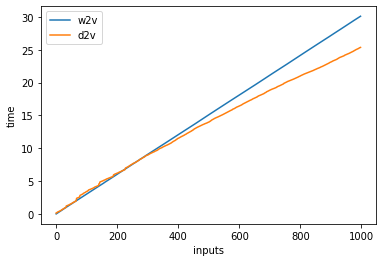

In [ ]:
#plot time as a function of inputs.

plt.plot(cumulative_w2v_time, label='w2v')
#plt.plot(cumulative_glove_time, label='glove')
#plt.plot(cumulative_fast_time, label='fast')
plt.plot(cumulative_d2v_time, label='d2v')

plt.legend(loc="upper left")
plt.ylabel('time')
plt.xlabel('inputs')
plt.show()

# Store Final Outputs

In [ ]:

#Word2vec output      
with open('/content/drive/MyDrive/wattpad_test/output_w2v.tsv',"w") as file:
    file.write(recommendations_w2v + "\n")

In [ ]:
#Doc2vec output
with open('/content/drive/MyDrive/wattpad_test/output_d2v.tsv',"w") as file:
    file.write(doc2vec_output + "\n")